In [1]:
import os
import time
import glob
import re
from functools import reduce

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import pandas as pd
import uproot_methods
import awkward


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



In [34]:
# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

class WHadProcessor(processor.ProcessorABC):
    """Processor used to find the pt rations"""
    def __init__(self):

        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("objecto",   "Objects")
        pt_axis             = hist.Bin("pt", r"$p_{T}$ (GeV)", 40, 200, 1200)
        pt2_axis             = hist.Bin("pt2", r"$p_{T}$ (GeV)", 40, 200, 1200)
        mass_axis           = hist.Bin("mass", r" mass (GeV)", 50, 0, 250)
        eta_axis            = hist.Bin("eta", r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity", r"N", 20, -0.5, 19.5)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)
        norm_axis           =hist.Bin("ts", "Tagger Score", 25, 0 , 1)
        norm2_axis           =hist.Bin("ts2", "Tagger Score", 25, 0 , 1)
        sdmass_axis           = hist.Bin("softdrop_mass", r" softdrop mass (GeV)", 50, 0, 250)

        self._accumulator = processor.dict_accumulator({
            "Htagged_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "WMDtagged_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "WMCtagged_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "genH_pt" :               hist.Hist("Counts", dataset_axis, pt_axis),
            "genW_pt" :               hist.Hist("Counts", dataset_axis, pt_axis),
            "genW,H_pt" :             hist.Hist("Counts", pt_axis, pt2_axis),
            "drH_b":                  hist.Hist("Counts", dataset_axis, r_axis),
            "dr_b":                  hist.Hist("Counts", dataset_axis, r_axis),
            "drW_j":                  hist.Hist("Counts", dataset_axis, r_axis),
            "sofm_fjs":               hist.Hist("Counts", dataset_axis, sdmass_axis),
            "sofm_h":               hist.Hist("Counts", dataset_axis, sdmass_axis),
            "sofm_w":                hist.Hist("Counts", dataset_axis, sdmass_axis),
            "sofm_htag":                hist.Hist("Counts", dataset_axis, sdmass_axis),
            "sofm_wmdtag":                hist.Hist("Counts", dataset_axis, sdmass_axis),
            "sofm_wmctag":                hist.Hist("Counts", dataset_axis, sdmass_axis),
            "m_fjs":               hist.Hist("Counts", dataset_axis, mass_axis),
            "m_h":               hist.Hist("Counts", dataset_axis, mass_axis),
            "m_w":                hist.Hist("Counts", dataset_axis, mass_axis),
            "m_htag":                hist.Hist("Counts", dataset_axis, mass_axis),
            "m_wmdtag":                hist.Hist("Counts", dataset_axis, mass_axis),
            "m_wmctag":                hist.Hist("Counts", dataset_axis, mass_axis),
            "Htag, Wtag":           hist.Hist("Counts", norm_axis, norm2_axis),
            
        })
        


    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        # We can access the data frame as usual
        # The dataset is written into the data frame
        # outside of this function
        
        #Fatjets
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content,
            deepTagMD_HbbvsQCD=df['FatJet_deepTagMD_HbbvsQCD'].content,
            softdrop=df["FatJet_msoftdrop"].content,
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content,
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content,
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content,
        )
        
        #Genj
        genj = JaggedCandidateArray.candidatesfromcounts(
            df['ngenj'],
            pt=df['Genj_pt'].content,
            eta=df['Genj_eta'].content,
            phi=df['Genj_phi'].content,
            mass=df['Genj_phi'].content*0,
            fromW = df['Genj_fromW'].content,
        )
        
        #Higgs vector
        Higgs = JaggedCandidateArray.candidatesfromcounts(
            df['ngenH'],
            pt=df['GenH_pt'].content, 
            eta=df['GenH_eta'].content, 
            phi=df['GenH_phi'].content, 
            mass=df['GenH_phi'].content*0,
            
        )
        
        Ws = JaggedCandidateArray.candidatesfromcounts(
            df['ngenW'],
            pt=df['GenW_pt'].content, 
            eta=df['GenW_eta'].content, 
            phi=df['GenW_phi'].content, 
            mass=df['GenW_phi'].content*0,
            
        )
        bjets = JaggedCandidateArray.candidatesfromcounts(
            df['ngenb'],
            pt=df['Genb_pt'].content, 
            eta=df['Genb_eta'].content, 
            phi=df['Genb_phi'].content, 
            mass=df['Genb_phi'].content*0,
            fromH = df['Genb_fromH'].content)
        
        #ak8s
        goodfjcut = ((fatjets.pt > 200))
        goodfatjets = fatjets[goodfjcut]
        
        #gen Higgs
        HmatchedFatJet = goodfatjets[goodfatjets.match(Higgs, deltaRCut=0.8)] # this selects all jets that have a Higgs inside
        passing_matchedFatJet = goodfatjets[(goodfatjets.match(Higgs, deltaRCut=0.8) & (goodfatjets.fromH>0.8365))]
        H_passing_FatJet = goodfatjets[(goodfatjets.fromH>0.8365)]
        
        #genW_MD
        WmatchedFatJet = goodfatjets[goodfatjets.match(Ws, deltaRCut=0.8)]
        WMD_passing_matchedFatJet = goodfatjets[(goodfatjets.match(Ws, deltaRCut=0.8) & (goodfatjets.fromW_MD>0.704) & (goodfatjets.fromH<0.8365))]
        WMD_passing_FatJet = goodfatjets[((goodfatjets.fromW_MD>0.704) & (goodfatjets.fromH<0.8365))]
        
        #genW_MC
        WMC_passing_matchedFatJet = goodfatjets[(goodfatjets.match(Ws, deltaRCut=0.8) & (goodfatjets.fromW_MC>0.918) & (goodfatjets.fromH<0.8365))]
        WMC_passing_FatJet = goodfatjets[((goodfatjets.fromW_MC>0.918) & (goodfatjets.fromH<0.8365))]
        
        #bs from Higgs
        Hmatchedb = bjets[bjets.fromH == 1]
        
        #jets from W
        Wmatchedj = genj[genj.fromW == 1]
        
        
        #angle between bs
        leadbfH = Hmatchedb[Hmatchedb.pt.argmax()]
        nleadbfH = Hmatchedb[Hmatchedb.pt.argmin()]
        leadbfHdr = np.sqrt((leadbfH.phi-nleadbfH.phi)**2+(leadbfH.eta-nleadbfH.eta)**2)
        
        leadb = bjets[bjets.pt.argmax()]
        nleadb = bjets[bjets.pt.argmin()]
        leadbdr = np.sqrt((leadb.phi-nleadb.phi)**2+(leadb.eta-nleadb.eta)**2)
        
        #angle between the js
        leadjfW = Wmatchedj[Wmatchedj.pt.argmax()]
        nleadjfW = Wmatchedj[Wmatchedj.pt.argmin()]
        leadjfWdr = np.sqrt((leadjfW.phi-nleadjfW.phi)**2+(leadjfW.eta-nleadjfW.eta)**2)
        
        # preselection of events
        bb = bjets.choose(2)
        has_close_bb = (bb.i0.p4.delta_r(bb.i1.p4) < 0.8).any()
        
        qq = genj.choose(2)
        has_close_qq = (qq.i0.p4.delta_r(qq.i1.p4)<0.6).any()
        #selection = df['nLepton']>=1
        
        has_close_both = (has_close_bb) & (has_close_qq)

        dataset = df["dataset"]

        # And fill the histograms
        output['Htagged_pt'].fill(objecto='Higgs tagged', pt=passing_matchedFatJet.pt.flatten())
        output['WMDtagged_pt'].fill(objecto='WMD tagged', pt=WMD_passing_matchedFatJet.pt.flatten())
        output['WMCtagged_pt'].fill(objecto='WMC tagged', pt=WMC_passing_matchedFatJet.pt.flatten())
        output['genH_pt'].fill(objecto='gen Higgs', pt=HmatchedFatJet.pt.flatten())
        output['genW_pt'].fill(objecto='gen W', pt=WmatchedFatJet.pt.flatten())
        output['drH_b'].fill(objecto='gen b', r=leadbfHdr.flatten())
        output['dr_b'].fill(objecto='gen b', r=leadbdr.flatten())
        output['drW_j'].fill(objecto = 'gen j', r =leadjfWdr.flatten())
        output['m_fjs'].fill(objecto= 'fatjet mass', mass = fatjets.mass.flatten())
        output['m_h'].fill(objecto= 'gen Higgs mass', mass = HmatchedFatJet.mass.flatten())
        output['m_w'].fill(objecto= 'gen W mass', mass = WmatchedFatJet.mass.flatten())
        output['m_htag'].fill(objecto= 'Higgs tagged mass', mass = H_passing_FatJet.mass.flatten())
        output['m_wmdtag'].fill(objecto= 'WMD tagged mass', mass = WMD_passing_FatJet.mass.flatten())
        output['m_wmctag'].fill(objecto= 'WMC tagged mass', mass = WMC_passing_FatJet.mass.flatten())
        output['sofm_fjs'].fill(objecto= 'fatjet softdrop mass', softdrop_mass = fatjets.softdrop[has_close_qq].flatten())
        output['sofm_h'].fill(objecto= 'gen Higgs softdrop mass', softdrop_mass = HmatchedFatJet.softdrop[has_close_qq].flatten())
        output['sofm_w'].fill(objecto= 'gen W softdrop mass', softdrop_mass = WmatchedFatJet.softdrop[has_close_qq].flatten())
        output['sofm_htag'].fill(objecto= 'Higgs tagged softdrop mass', softdrop_mass = H_passing_FatJet.softdrop[has_close_qq].flatten())
        output['sofm_wmdtag'].fill(objecto= 'WMD tagged softdrop mass', softdrop_mass = WMD_passing_FatJet.softdrop[has_close_qq].flatten())
        output['sofm_wmctag'].fill(objecto= 'WMC tagged softdrop mass', softdrop_mass = WMC_passing_FatJet.softdrop[has_close_qq].flatten())
        output['Htag, Wtag'].fill(ts=fatjets.fromH.flatten(), ts2=fatjets.fromW_MC.flatten())

        return output

    def postprocess(self, accumulator):
        return accumulator


In [35]:
overwrite = True

    # load the config and the cache

    # download file from eos in the future?

    # Inputs are defined in a dictionary
    # dataset : list of files
fileset_sig = {
        'WHgen': ['/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_1.root', 
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_2.root',
                           '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_3.root',
                           '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_4.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_5.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_6.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_7.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_8.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_9.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_10.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_11.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_12.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_13.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_14.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_15.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_16.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_17.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_18.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_19.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_20.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_21.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_22.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_23.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_24.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_25.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_26.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_27.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_28.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_29.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_30.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_31.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_32.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_33.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_34.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_35.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_36.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_37.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_38.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_39.root',
                            '/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/nanoSkim_40.root',
                           ]}
fileset_ttjets1l = {'ttjets1l': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/TTJets_SingleLept*/nanoSkim_*.root')}
fileset_ttjets2l = {'ttjets1l': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p20/TTJets_DiLept*/nanoSkim_*.root')}

output_sig = processor.run_uproot_job(fileset_sig,
                                  treename='Events',
                                  processor_instance=WHadProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 1, 'function_args': {'flatten': False}},
                                  chunksize=500000,
                                 )

output_ttjets1l = processor.run_uproot_job(fileset_ttjets1l,
                                 treename='Events',
                                  processor_instance=WHadProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 1, 'function_args': {'flatten': False}},
                                  chunksize=500000,
                                 )

output_ttjets2l = processor.run_uproot_job(fileset_ttjets2l,
                                 treename='Events',
                                  processor_instance=WHadProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 1, 'function_args': {'flatten': False}},
                                  chunksize=500000,
                                 )



%matplotlib inline
outdir = "/home/users/ewallace/public_html/plots"    
    


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=40.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:348: RuntimeWarning: overflow encountered in sinh
  return self._trymemo("z",lambda self: self.pt * self.awkward.numpy.sinh(self.eta))
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._trymemo("z",lambda self: self.pt * self.awkward.numpy.sinh(self.eta))
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:404: RuntimeWarning: overflow encountered in cosh
  return self._trymemo("p",lambda self: self["

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()


HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=42.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:348: RuntimeWarning: overflow encountered in sinh
  return self._trymemo("z",lambda self: self.pt * self.awkward.numpy.sinh(self.eta))
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._trymemo("z",lambda self: self.pt * self.awkward.numpy.sinh(self.eta))
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:404: RuntimeWarning: overflow encountered in cosh
  return self._trymemo("p",lambda self: self["fPt"]*self.awkward.numpy.cosh(self["fEta"]))
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:404: RuntimeWarning: invalid value encountered in multip

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=12.0), HTML(value='')))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot/source/cursor.py:73: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return source.data(start, stop).tostring()
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:348: RuntimeWarning: overflow encountered in sinh
  return self._trymemo("z",lambda self: self.pt * self.awkward.numpy.sinh(self.eta))
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._trymemo("z",lambda self: self.pt * self.awkward.numpy.sinh(self.eta))
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:404: RuntimeWarning: overflow encountered in cosh
  return self._trymemo("p",lambda self: self["

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


<AxesSubplot:xlabel='$p_{T}$ (GeV)', ylabel='Efficiency'>

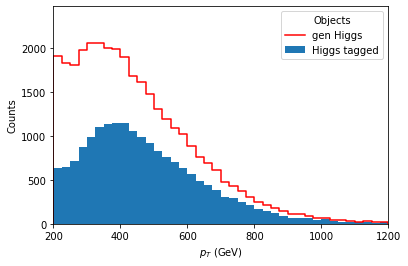

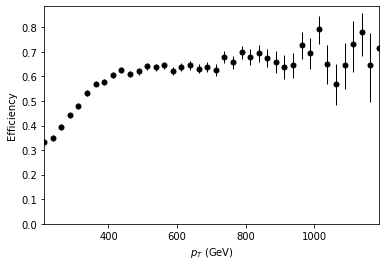

In [29]:
hist.plot1d(output_sig["Htagged_pt"], density=False, stack=True)
hist.plot1d(output_sig["genH_pt"], density=False, stack=False, line_opts={'color':'r'})

# make ratio plot
output_sig["Htagged_pt"].label = "Efficiency"
hist.plotratio(
num=output_sig["Htagged_pt"].sum("objecto"),
denom=output_sig["genH_pt"].sum("objecto"),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='clopper-pearson')

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


<AxesSubplot:xlabel='$p_{T}$ (GeV)', ylabel='Efficiency'>

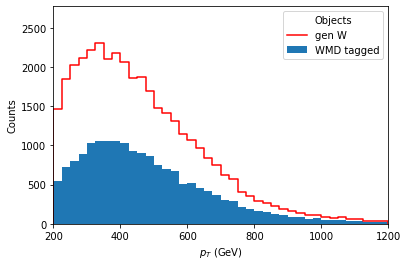

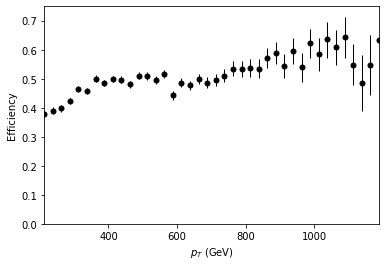

In [66]:
hist.plot1d(output_sig["WMDtagged_pt"], density=False, stack=True)
hist.plot1d(output_sig["genW_pt"], density=False, stack=False, line_opts={'color':'r'})

# make ratio plot
output_sig["WMDtagged_pt"].label = "Efficiency"
hist.plotratio(
num=output_sig["WMDtagged_pt"].sum("objecto"),
denom=output_sig["genW_pt"].sum("objecto"),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='clopper-pearson')

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


<AxesSubplot:xlabel='$p_{T}$ (GeV)', ylabel='Efficiency'>

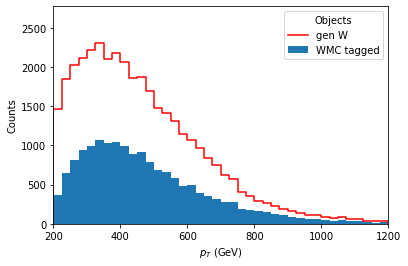

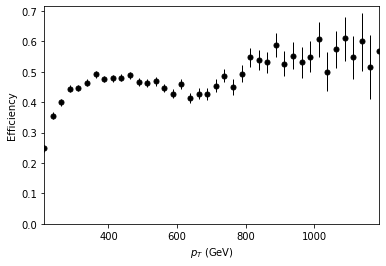

In [67]:
hist.plot1d(output_sig["WMCtagged_pt"], density=False, stack=True)
hist.plot1d(output_sig["genW_pt"], density=False, stack=False, line_opts={'color':'r'})

# make ratio plot
output_sig["WMCtagged_pt"].label = "Efficiency"
hist.plotratio(
num=output_sig["WMCtagged_pt"].sum("objecto"),
denom=output_sig["genW_pt"].sum("objecto"),
error_opts={
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1,},
unc='clopper-pearson')

<AxesSubplot:xlabel='$p_{T}$ (GeV)', ylabel='$p_{T}$ (GeV)'>

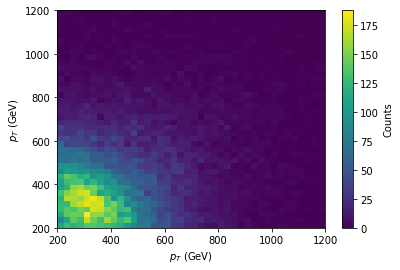

In [68]:
hist.plot2d(output_sig['genW,H_pt'], xaxis = 'pt', )

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


<AxesSubplot:xlabel='$\\Delta R$', ylabel='Counts'>

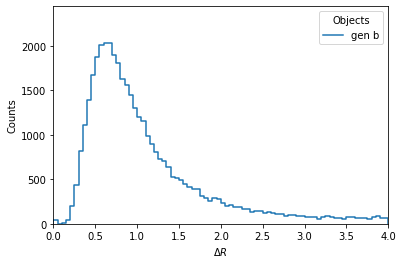

In [69]:
hist.plot1d(output_sig["drH_b"], density=False, stack=False, line_opts={'color':'tab:blue'})
#hist.plot1d(output["dr_b"], density=False, stack=True)

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


<AxesSubplot:xlabel='$\\Delta R$', ylabel='Counts'>

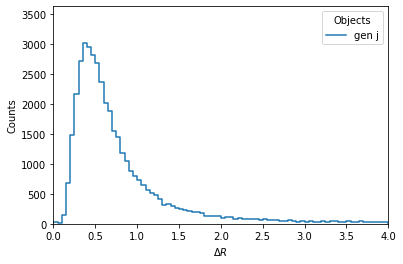

In [70]:
hist.plot1d(output_sig["drW_j"], density=False, stack=False, line_opts={'color':'tab:blue'})

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


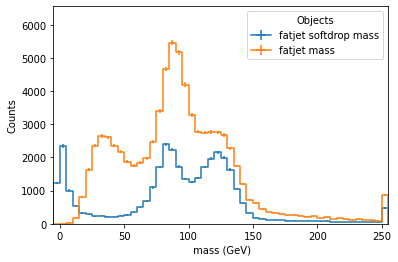

In [67]:
outdir = "/home/users/ewallace/public_html/plots"
    
ax = hist.plot1d(output_sig['sofm_fjs'], density=False, stack=False, overflow='all')
hist.plot1d(output_sig['m_fjs'], density=False, stack=False, overflow='all')
ax.figure.savefig(os.path.join(outdir, "sdmassvmass3.png"))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


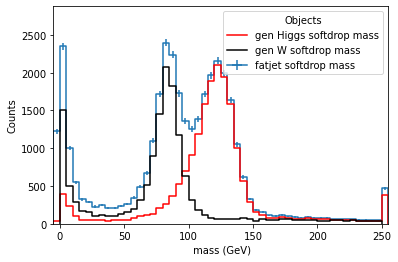

In [68]:
ax1 = hist.plot1d(output_sig['sofm_fjs'], density=False, stack=False, overflow='all')
hist.plot1d(output_sig['sofm_h'], density=False, stack=False, line_opts={'color':'r'}, overflow = 'all')
hist.plot1d(output_sig['sofm_w'], density=False, stack=False, line_opts={'color':'k'})
ax1.figure.savefig(os.path.join(outdir, "gensdmass3.png"))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwar

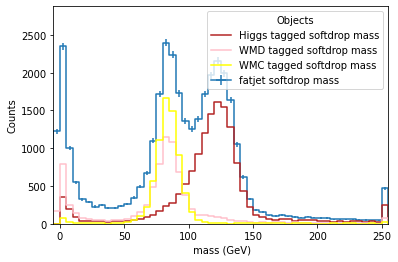

In [69]:
ax2 = hist.plot1d(output_sig['sofm_fjs'], density=False, stack=False, overflow='all')
hist.plot1d(output_sig['sofm_htag'], density=False, stack=False, line_opts={'color':'firebrick'}, overflow = 'all')
hist.plot1d(output_sig['sofm_wmdtag'], density=False, stack=False, line_opts={'color':'pink'}, overflow = 'all')
hist.plot1d(output_sig['sofm_wmctag'], density=False, stack=False, line_opts={'color':'yellow'}, overflow = 'all')
ax2.figure.savefig(os.path.join(outdir, "taggedsdmass3.png"))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


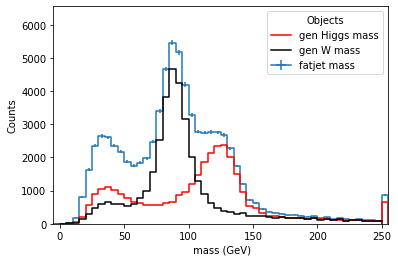

In [70]:
ax3 = hist.plot1d(output_sig['m_fjs'], density=False, stack=False, overflow='all')
hist.plot1d(output_sig['m_h'], density=False, stack=False, line_opts={'color':'r'}, overflow = 'all')
hist.plot1d(output_sig['m_w'], density=False, stack=False, line_opts={'color':'k'})
ax3.figure.savefig(os.path.join(outdir, "genmass3.png"))

<AxesSubplot:xlabel='Tagger Score', ylabel='Tagger Score'>

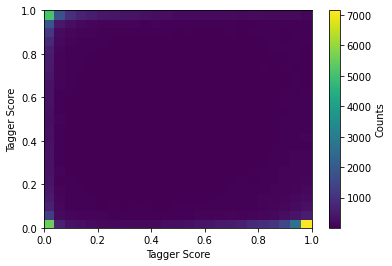

In [43]:
hist.plot2d(output_sig['Htag, Wtag'], xaxis = 'ts', )

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


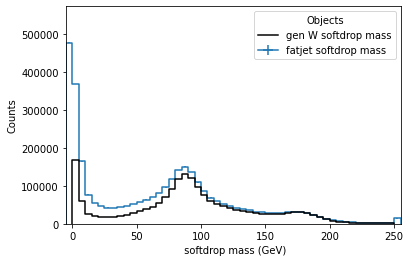

In [36]:
ax1 = hist.plot1d(output_ttjets1l['sofm_fjs'], density=False, stack=False, overflow='all')
hist.plot1d(output_ttjets1l['sofm_w'], density=False, stack=False, line_opts={'color':'k'})
ax1.figure.savefig(os.path.join(outdir, "gensdmastt1l.png"))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


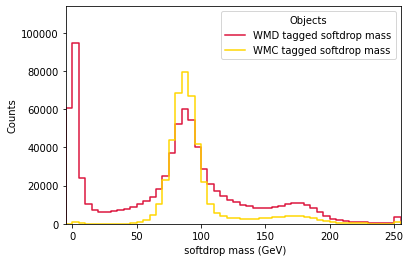

In [37]:
ax2 = hist.plot1d(output_ttjets1l['sofm_wmdtag'], density=False, stack=False, line_opts={'color':'crimson'}, overflow = 'all')
hist.plot1d(output_ttjets1l['sofm_wmctag'], density=False, stack=False, line_opts={'color':'gold'}, overflow = 'all')
ax2.figure.savefig(os.path.join(outdir, "taggedsdmasstt1l.png"))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


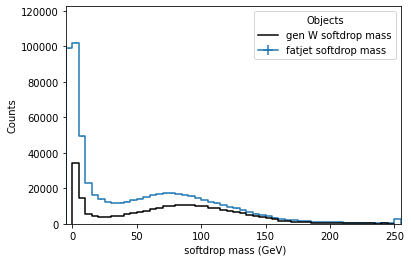

In [38]:
ax1 = hist.plot1d(output_ttjets2l['sofm_fjs'], density=False, stack=False, overflow='all')
hist.plot1d(output_ttjets2l['sofm_w'], density=False, stack=False, line_opts={'color':'k'})
ax1.figure.savefig(os.path.join(outdir, "gensdmastt2l.png"))

/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


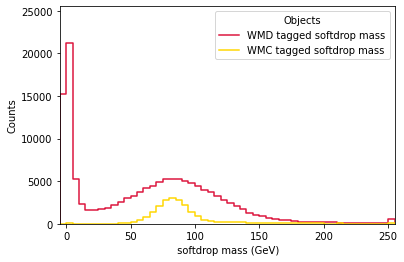

In [39]:
ax2 = hist.plot1d(output_ttjets2l['sofm_wmdtag'], density=False, stack=False, line_opts={'color':'crimson'}, overflow = 'all')
hist.plot1d(output_ttjets2l['sofm_wmctag'], density=False, stack=False, line_opts={'color':'gold'}, overflow = 'all')
ax2.figure.savefig(os.path.join(outdir, "taggedsdmasstt2l.png"))